In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import numpy as np

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images_gt = train_images
test_images_gt = test_images

#X->x->X'
im = []

for i in range(train_images.shape[0]):
    tmp_org = train_images[i]
    tmp = Image.fromarray(tmp_org)  
    tmp = tmp.resize((16, 16))#x
    tmp = tmp.resize((32, 32))#X'
    tmp = np.asarray(tmp)
  
    #augmentation
    tmp_flip_ud = np.flipud(tmp)
    tmp_flip_lr = np.fliplr(tmp)
    im.append(np.expand_dims(tmp, axis=0))    

train_images = np.concatenate(im, axis=0)/255.0
train_images_gt = train_images_gt/255.0

#X->x->X' SR!!
im = []

for i in range(test_images.shape[0]):
    tmp = Image.fromarray(test_images[i])
    tmp = tmp.resize((16, 16))#x
    tmp = tmp.resize((32, 32))#X'
    tmp = np.asarray(tmp)
    im.append(np.expand_dims(tmp, axis=0))

test_images = np.concatenate(im, axis=0)
test_images = test_images/255.0
test_images_gt = test_images_gt/255.0

#gaussian noise
def add_noise_and_clip_data(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
    data = data + noise
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_images)
test_data_noisy = add_noise_and_clip_data(test_images)

print(train_images.shape, test_images.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


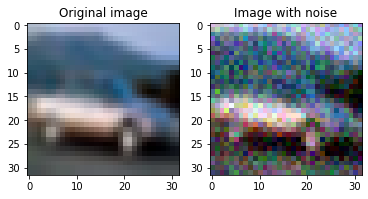

In [3]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_images[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

(50000, 32, 32, 3)


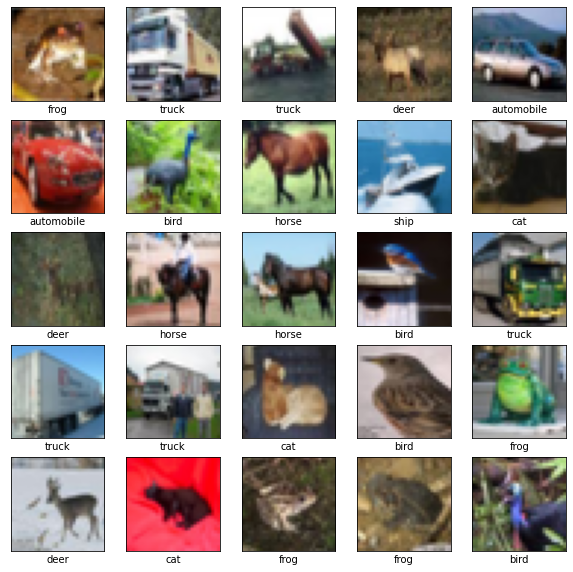

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(train_images_gt.shape)

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)   
    plt.imshow(train_images_gt[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[train_labels[i][0]])
    
plt.show()

In [5]:
from tensorflow.keras.layers import Conv2DTranspose, Concatenate

conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')
conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')
conv3 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')
conv4 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')
#conv5 = tf.keras.layers.Conv2D(3, 3, padding = 'same')

#-----------------------
deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')
deconv2 = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')
deconv3 = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')
deconv4 = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')
deconv5 = tf.keras.layers.Conv2DTranspose(3, 3, padding = 'same')
#---------------------------

inputs = tf.keras.layers.Input(shape= [32,32,3])

tmp = Concatenate()([conv4(inputs), deconv1(inputs)])
tmp = Concatenate()([conv3(tmp), deconv2(tmp)])
tmp = Concatenate()([conv2(tmp), deconv3(tmp)])
tmp = Concatenate()([conv1(tmp), deconv4(tmp)])
tmp = deconv5(tmp) + inputs

model = tf.keras.Model(inputs = inputs, outputs = tmp)

# tmp = conv1(inputs)
# tmp = conv2(tmp)
# tmp = conv3(tmp)
# tmp = conv4(tmp)
# tmp = conv5(tmp) + inputs

Let's display the architecture of our model so far.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 128)  0           conv2d_3[0][0]                   
                                                                 conv2d_transpose[0][0]       

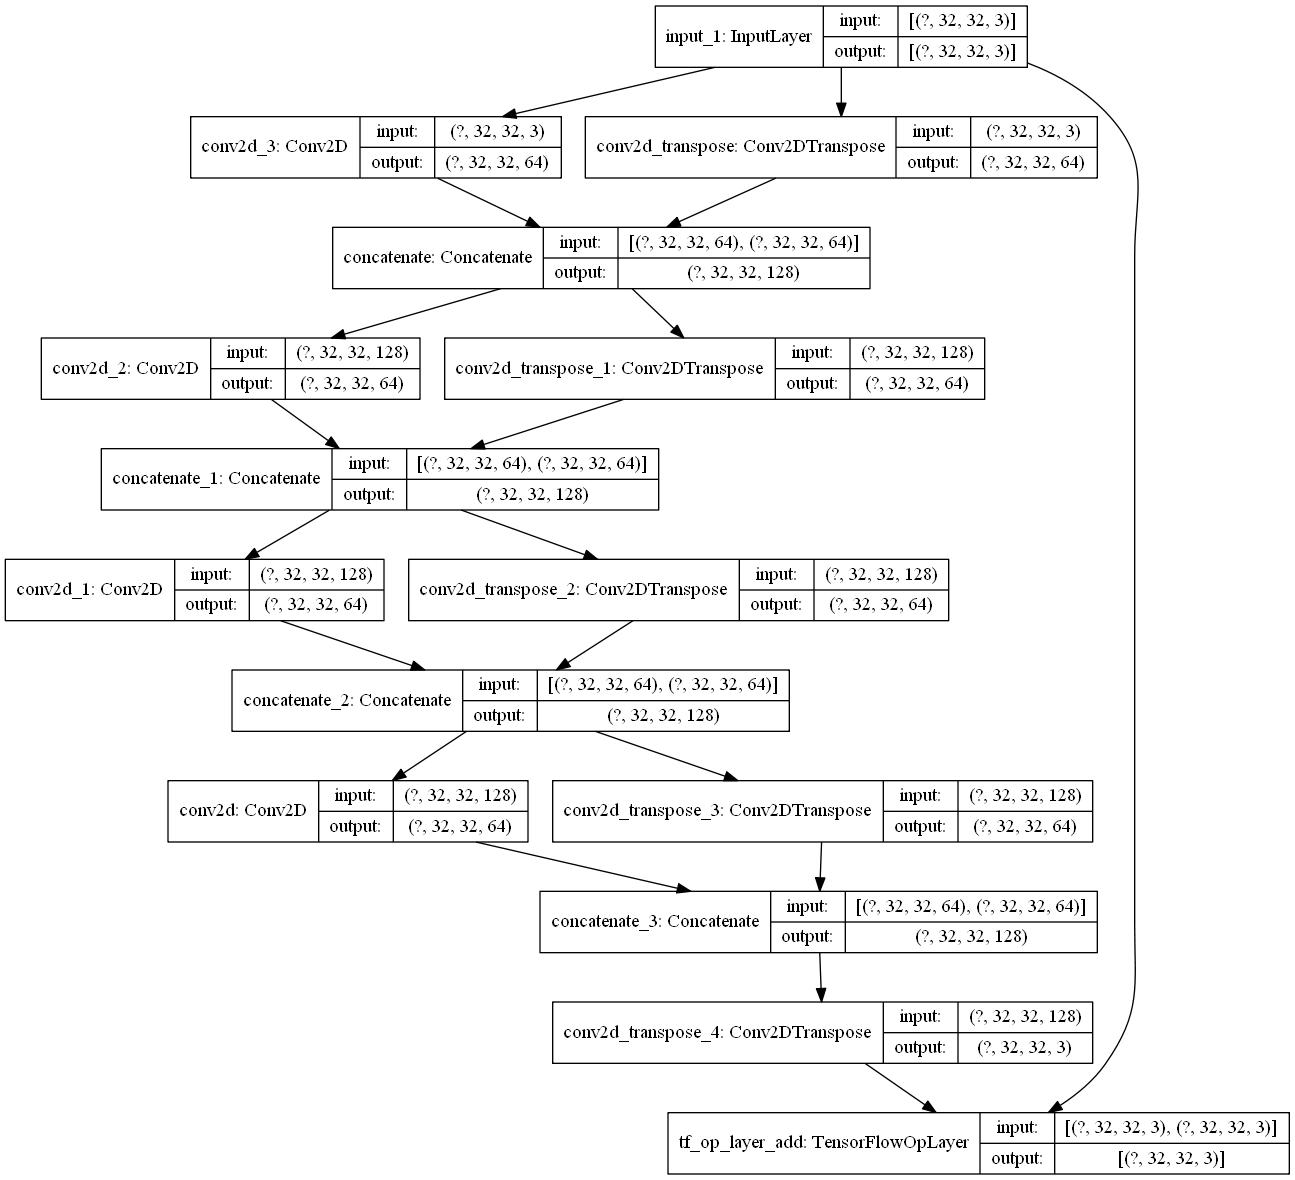

In [6]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True)

### Compile and train the model

In [7]:
model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['accuracy']
             )

model.fit(train_data_noisy, train_images, epochs=10, validation_data=(test_data_noisy, test_images))
#model.fit(train_images, train_images_gt, epochs=10, validation_data=(test_images, test_images_gt))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 27s 537us/sample - loss: 0.0258 - accuracy: 0.7994 - val_loss: 0.0234 - val_accuracy: 0.8142
Epoch 2/10
50000/50000 [==============================] - 25s 502us/sample - loss: 0.0229 - accuracy: 0.8175 - val_loss: 0.0229 - val_accuracy: 0.8268
Epoch 3/10
50000/50000 [==============================] - 25s 499us/sample - loss: 0.0225 - accuracy: 0.8201 - val_loss: 0.0226 - val_accuracy: 0.8243
Epoch 4/10
50000/50000 [==============================] - 25s 504us/sample - loss: 0.0222 - accuracy: 0.8213 - val_loss: 0.0220 - val_accuracy: 0.8256
Epoch 5/10
50000/50000 [==============================] - 25s 503us/sample - loss: 0.0220 - accuracy: 0.8222 - val_loss: 0.0221 - val_accuracy: 0.8251
Epoch 6/10
50000/50000 [==============================] - 25s 497us/sample - loss: 0.0219 - accuracy: 0.8224 - val_loss: 0.0218 - val_accuracy: 0.8262
Epoch 7/10
50000/50000 [====================

### Evaluate the model

(10000, 32, 32, 3)


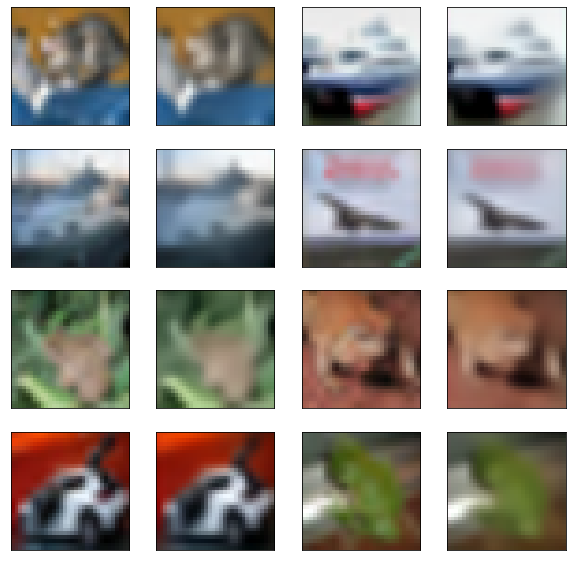

In [8]:
prediction = model.predict(test_images)

print(prediction.shape)

prediction = np.maximum(0, np.minimum(prediction, 1))#guess what?

plt.figure(figsize=(10,10))

for i in range(8):
    plt.subplot(4,4,2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

    plt.subplot(4,4,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(prediction[i], cmap=plt.cm.binary)

plt.show()

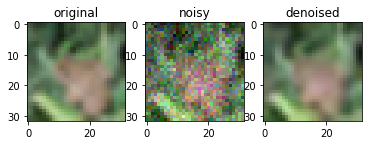

In [9]:
test_data_denoised = model.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_images[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [10]:
test_acc = model.evaluate(test_images, test_images_gt, verbose=2)

10000/10000 - 2s - loss: 0.0430 - accuracy: 0.8344


In [12]:
MSE = np.mean((prediction - test_images_gt)*(prediction - test_images_gt))
print('MSE: %0.4f' % MSE)

MSE: 0.0037
